In [3]:
pip install pandas unicode matplotlib seaborn scikit-learn plotly & pip install --upgrade nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.10.3
    Uninstalling nbformat-5.10.3:
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\HP\\OneDrive\\Documents\\Eduardo Toledo\\MIAD\\final_project\\source\\.venv\\Lib\\site-packages\\~0format-5.10.3.dist-info'
Check the permissions.



# 1. Enrichment with New Features
1.1 Add a new variable called Power_Factor </p>
1.2 Decompose the Date dimension into its components and adding cyclic coding</p>
1.3 The output of this process is a new datamart,**silver** . </p>

In [10]:
import pandas as pd
import numpy as np


df = pd.read_csv('../data/output/consumo_datamart_bronze.csv')

# Conver 'Fecha_Hora' to datetime 
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Factor_Potencia
epsilon = 1e-10
denominador = np.sqrt(np.square(df['Active_energy']) + np.square(df['Reactive_energy'])) + epsilon
df['Factor_Potencia'] = df['Active_energy'] / denominador

# Extract Time components
df['DiaSemana'] = df['Fecha'].dt.dayofweek  # Mon=0, Sun=6
df['Hora'] = df['Fecha'].dt.hour
df['Mes'] = df['Fecha'].dt.month

# Apply cyclic coding
# Weekday
df['Dia_Sin'] = np.sin(df['DiaSemana'] * (2. * np.pi / 7))
df['Dia_Cos'] = np.cos(df['DiaSemana'] * (2. * np.pi / 7))

# Hour
df['Hora_Sin'] = np.sin(df['Hora'] * (2. * np.pi / 24))
df['Hora_Cos'] = np.cos(df['Hora'] * (2. * np.pi / 24))

# Month
df['Mes_Sin'] = np.sin((df['Mes'] - 1) * (2. * np.pi / 12))
df['Mes_Cos'] = np.cos((df['Mes'] - 1) * (2. * np.pi / 12))

# Now 'df' contains the new computed  variables alongside any other original columns
df=df[['Fecha', 'DiaSemana','Hora','Mes','Active_energy','Reactive_energy','Voltaje_FC','Voltaje_FA','Factor_Potencia','ClienteId','Dia_Sin','Dia_Cos', 'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos','Sector_Economico']]
output_filepath = '../data/output/consumo_datamart_silver.csv'
df.to_csv(output_filepath, index=False)


# 2. Apply One-Hot Encoding to sector_economico </p>
2.1 The resulting repository is named silver_sector_econ_ohe

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd


df = pd.read_csv('../data/output/consumo_datamart_silver.csv')

# OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
ct = ColumnTransformer(transformers=[('encoder', encoder, ['Sector_Economico'])], remainder='passthrough')
# Appply OHE
df_encoded = ct.fit_transform(df)

# Reconstruct the orig dataframe with the new colums
columns = ct.named_transformers_['encoder'].get_feature_names_out(input_features=['Sector_Economico'])
new_columns = list(columns)  +  [col for col in df.columns if col != 'Sector_Economico']
df_encoded = pd.DataFrame(df_encoded, columns=new_columns)
df_encoded['Sector_Economico'] = df['Sector_Economico']
df_encoded['ClienteId'] = df['ClienteId']

output_filepath = '../data/output/consumo_datamart_silver_sectorecon_ohe.csv'
df_encoded.to_csv(output_filepath, index=False)
#df_encoded.info()

### Internal Validation between the silver repository and the silver_with_ohe repositor

In [18]:
import pandas as pd
from  IPython.display import display
df = pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FC', 'Voltaje_FA', 'Factor_Potencia']
# Group by 'Sector_Economico' and calculate the mean for each  column
mean_values = df.groupby('Sector_Economico')[features].mean()
display(mean_values)

df = pd.read_csv('../data/output/consumo_datamart_silver.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FC', 'Voltaje_FA', 'Factor_Potencia']
# Group by 'Sector_Economico' and calculate the mean for each  column
mean_values = df.groupby('Sector_Economico')[features].mean()
display(mean_values)



,Active_energy,Reactive_energy,Voltaje_FC,Voltaje_FA,Factor_Potencia
Sector_Economico,,,,,
captacion_tratamiento_distribucion_agua,1.244150,1.254853,2001.797845,2004.971168,0.647375
cultivo_arboles_frutales_nueces,1.890849,0.591150,1466.652698,1373.244396,0.853339
cultivo_frutos_nueces_arboles_arbustos,0.582958,0.317171,1746.112200,1751.632524,0.773252
cultivo_hortalizas,0.105204,0.126697,1927.493298,1928.073488,0.490673
cultivo_hortalizas_melones_raices_tuberculos,0.967254,0.176584,2158.306393,2160.236864,0.857788
elaboracion_cacao_chocolate_productos_confiteria,2.659339,1.687157,615.483875,615.392029,0.837835
venta_mayor_metales_minerales_metaliferos,1.116844,0.578136,1000.035057,1000.917018,0.779255


,Active_energy,Reactive_energy,Voltaje_FC,Voltaje_FA,Factor_Potencia
Sector_Economico,,,,,
captacion_tratamiento_distribucion_agua,1.244150,1.254853,2001.797845,2004.971168,0.647375
cultivo_arboles_frutales_nueces,1.890849,0.591150,1466.652698,1373.244396,0.853339
cultivo_frutos_nueces_arboles_arbustos,0.582958,0.317171,1746.112200,1751.632524,0.773252
cultivo_hortalizas,0.105204,0.126697,1927.493298,1928.073488,0.490673
cultivo_hortalizas_melones_raices_tuberculos,0.967254,0.176584,2158.306393,2160.236864,0.857788
elaboracion_cacao_chocolate_productos_confiteria,2.659339,1.687157,615.483875,615.392029,0.837835
venta_mayor_metales_minerales_metaliferos,1.116844,0.578136,1000.035057,1000.917018,0.779255


# 3 Correlation Analysis.

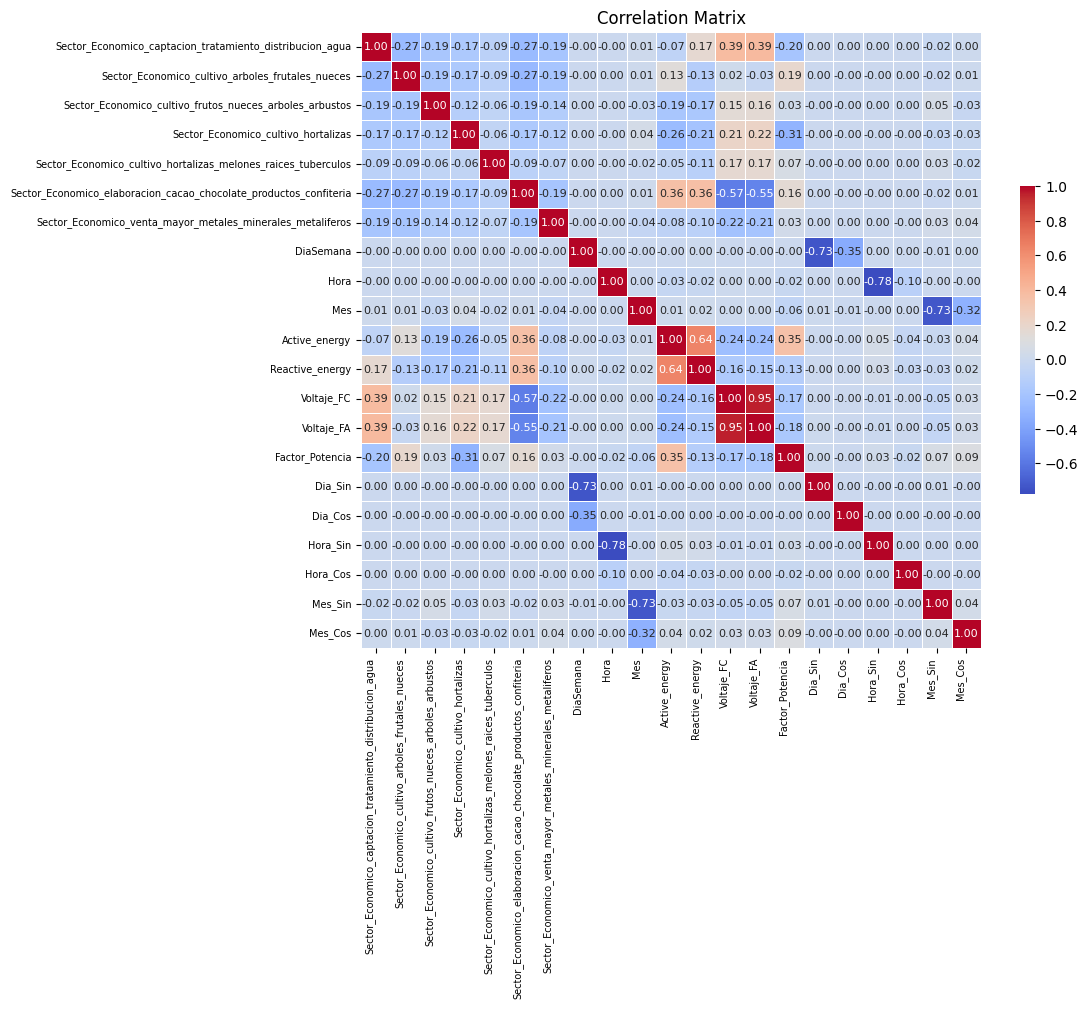

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_df = pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')

columns_of_interest= [col for col in combined_df.columns if col != 'Fecha' 
                                                and col != 'Sector_Economico' 
                                                and col != 'ClienteId' ] 
data_subset = combined_df[columns_of_interest]

# Compute the correlation matrix
corr_matrix = data_subset.corr()

# Heatmap
plt.figure(figsize=(10, 8))  
ax=sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5},annot_kws={"size": 8})
# Rotates labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')  
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)  

ax.tick_params(axis='x', labelsize=7) 
ax.tick_params(axis='y', labelsize=7)  
plt.title('Correlation Matrix')
plt.show()


In [2]:
corr_matrix

,Sector_Economico_captacion_tratamiento_distribucion_agua,Sector_Economico_cultivo_arboles_frutales_nueces,Sector_Economico_cultivo_frutos_nueces_arboles_arbustos,Sector_Economico_cultivo_hortalizas,Sector_Economico_cultivo_hortalizas_melones_raices_tuberculos,Sector_Economico_elaboracion_cacao_chocolate_productos_confiteria,Sector_Economico_venta_mayor_metales_minerales_metaliferos,DiaSemana,Hora,Mes,...,Reactive_energy,Voltaje_FC,Voltaje_FA,Factor_Potencia,Dia_Sin,Dia_Cos,Hora_Sin,Hora_Cos,Mes_Sin,Mes_Cos
Sector_Economico_captacion_tratamiento_distribucion_agua,1.000000,-0.268013,-0.186312,-0.168497,-0.091105,-0.268013,-0.193455,-0.000292,-0.000067,0.014904,...,0.170051,0.389523,0.393915,-0.198671,0.000387,0.000235,0.000115,0.000026,-0.022219,0.004309
Sector_Economico_cultivo_arboles_frutales_nueces,-0.268013,1.000000,-0.187406,-0.169487,-0.091640,-0.269588,-0.194591,-0.000110,0.000166,0.010851,...,-0.126321,0.019572,-0.031808,0.187742,0.000160,-0.000171,-0.000170,0.000025,-0.016631,0.007130
Sector_Economico_cultivo_frutos_nueces_arboles_arbustos,-0.186312,-0.187406,1.000000,-0.117820,-0.063704,-0.187406,-0.135272,0.000658,-0.000108,-0.034859,...,-0.173148,0.148736,0.156116,0.025746,-0.000779,-0.000105,0.000098,0.000090,0.054353,-0.026862
Sector_Economico_cultivo_hortalizas,-0.168497,-0.169487,-0.117820,1.000000,-0.057613,-0.169487,-0.122337,0.000099,-0.000035,0.043431,...,-0.210245,0.213834,0.216348,-0.311023,-0.000104,-0.000574,-0.000031,-0.000139,-0.034157,-0.026627
Sector_Economico_cultivo_hortalizas_melones_raices_tuberculos,-0.091105,-0.091640,-0.063704,-0.057613,1.000000,-0.091640,-0.066147,0.000451,-0.000045,-0.016287,...,-0.106080,0.170193,0.170450,0.066665,-0.000516,-0.000173,0.000036,0.000068,0.029799,-0.021589
Sector_Economico_elaboracion_cacao_chocolate_productos_confiteria,-0.268013,-0.269588,-0.187406,-0.169487,-0.091640,1.000000,-0.194591,-0.000110,0.000166,0.010851,...,0.364743,-0.572490,-0.545304,0.158568,0.000160,-0.000171,-0.000170,0.000025,-0.016631,0.007130
Sector_Economico_venta_mayor_metales_minerales_metaliferos,-0.193455,-0.194591,-0.135272,-0.122337,-0.066147,-0.194591,1.000000,-0.000327,-0.000169,-0.042124,...,-0.095388,-0.220153,-0.205055,0.034886,0.000241,0.000841,0.000195,-0.000094,0.031276,0.038160
DiaSemana,-0.000292,-0.000110,0.000658,0.000099,0.000451,-0.000110,-0.000327,1.000000,-0.000236,-0.003257,...,0.002007,-0.001777,-0.001915,-0.001249,-0.734358,-0.353816,0.000165,0.000093,-0.005419,0.001208
Hora,-0.000067,0.000166,-0.000108,-0.000035,-0.000045,0.000166,-0.000169,-0.000236,1.000000,0.000207,...,-0.023664,0.004612,0.004515,-0.021171,0.000159,0.000307,-0.775869,-0.102471,-0.000277,-0.000010
Mes,0.014904,0.010851,-0.034859,0.043431,-0.016287,0.010851,-0.042124,-0.003257,0.000207,1.000000,...,0.020357,0.003939,0.003231,-0.058402,0.007637,-0.011279,-0.000161,0.000072,-0.733400,-0.320057


## 3.1 Interpretation from the perspective of anomaly detection

English Version: </p>
Active Energy and Reactive Energy: There is a moderate correlation (approximately 0.64) between active energy and reactive energy, indicating that changes in active energy consumption are accompanied by similar changes in reactive energy consumption. Despite their correlation, both variables are important for comprehensive analysis as they offer different perspectives on energy consumption and system efficiency.

Voltage Measurements (Voltage_FA and Voltage_FC): There is a very high correlation (approximately 0.95) between the voltage measurements of phases FA and FC. This high correlation suggests that voltage levels in these phases tend to move together. Despite this correlation, monitoring voltage in different phases remains important for identifying specific phase problems or imbalances that may not affect all phases equally.

Overall, although some variables are highly correlated, each offers unique insights into the operation of the electrical system. For comprehensive anomaly detection, it is recommended to consider all variables, as this allows for the identification of a wider range of anomalies, specifically energy consumption variables and time dimensions. 

Version in Spanish: </p>
Energía Activa y Energía Reactiva: Hay una moderada correlación (aproximadamente 0.64) entre la energía activa y la energía reactiva, lo que indica que los cambios en el consumo de energía activa  van acompañados de cambios similares en el consumo de energía reactiva. A pesar de su correlación, ambas variables son importantes para un análisis integral, ya que ofrecen distintas perspectivas sobre el consumo de energía y la eficiencia del sistema.


Medidas de Voltaje (Voltaje_FA y Voltaje_FC): Hay una correlación muy alta (aproximadamente 0.95) entre las mediciones de voltaje de las fases FA y FC. Esta alta correlación sugiere que los niveles de voltaje en estas fases tienden a moverse juntos. A pesar de esta correlación, la monitorización del voltaje en diferentes fases sigue siendo importante para identificar problemas específicos de cada fase o desequilibrios que podrían no afectar a todas las fases por igual.



En general, aunque algunas variables están altamente correlacionadas, cada una ofrece perspectivas únicas sobre el funcionamiento del sistema eléctrico. Para una detección de anomalías completa, es recomendable considerar todas las variables, ya que esto permite identificar un rango más amplio de anomalías, especioficamente las variables de consumo de eneegia y las dimensiones de tiempo.


# 4 Importance of Features: Dimensionality Reduction via PCA

### 4.1 Using the silver repository and performing dimensionality reduction with the consumption variables [Voltaje_FA, Voltaje_FC, Active_Energy, Reactive_Energy, and Power_Factor].

Text(0.5, 1.0, 'PCA Explained')

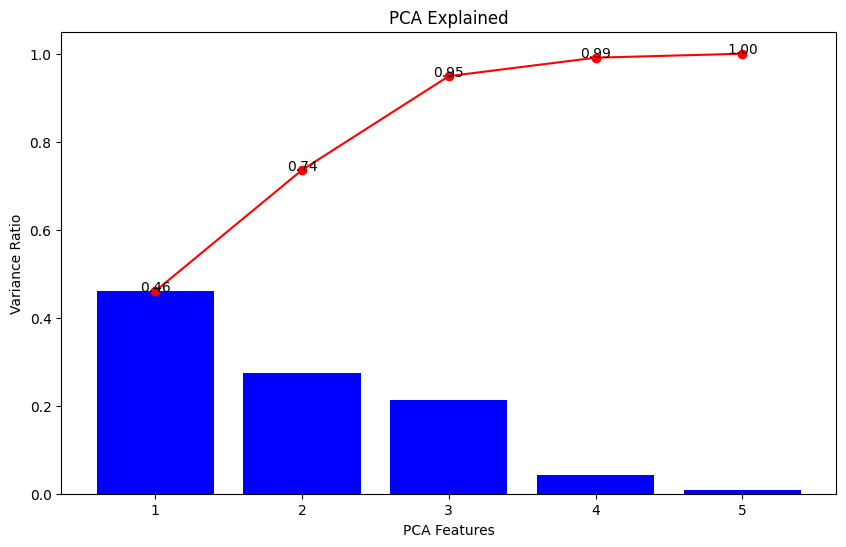

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load  data
combined_df = pd.read_csv('../data/output/consumo_datamart_silver.csv')


features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC','Factor_Potencia']

x = combined_df.loc[:, features].values

# Standardizing the features
x_standardized = StandardScaler().fit_transform(x)

# Apply PCA without specifying the number of components to retain all components
pca = PCA()
pca.fit(x_standardized)

# Calculate the variance ratios
variance_ratios = pca.explained_variance_ratio_

# Plot the explained variances for each component
features_range = range(1, pca.n_components_ + 1)
plt.figure(figsize=(10, 6))
plt.bar(features_range, variance_ratios, color='blue', label='Individual Explained Variance')

# Calculate and plot the cumulative explained variance
cumulative_variance_ratios = np.cumsum(variance_ratios)
plt.plot(features_range, cumulative_variance_ratios, c='red', marker='o', linestyle='-', label='Cumulative Explained Variance')

# Annotate the cumulative variance percentage on the plot
for i, cv in enumerate(cumulative_variance_ratios):
    plt.text(i + 1, cv, f"{cv:.2f}", ha='center')

# Adding labels and title
plt.xlabel('PCA Features')
plt.ylabel('Variance Ratio')
plt.xticks(features_range)
plt.title('PCA Explained')


### 4.2 Principal Component Analysis (PCA with 3 components) to obtain the importance of the variables - Biplot Diagrams

The result of this analysis consists of biplot diagrams aimed at visualizing the loadings, which represent the contribution and direction of each original variable to the principal component, in order to understand patterns and relationships between variables.

*Interpretation:*

Vectors pointing in the same direction indicate positive correlation between variables.
Vectors pointing in opposite directions indicate negative correlation between variables.

The length of a vector represents its contribution to the principal component.

 

In Spanish: 

El resultado de este analisis son diagramas de biplot con el fin de visualizar  los loadings que representan la contribution  y la direccion de cada original variable al componente principal, con el fin de entender los patrones y relaciones entyre variables.
 
 Interpretacion:

Vectores apuntando a la misma direccion  indican correlacion positiva entyre variaables
Vectores apuntando en direccion opuesta  indican correlacion negativa entyre variaables


La longitud de un vector  representa la contribucion de esta en el componente principal.

Loadings directionality


,PC1,PC2,PC3
Active_energy,0.435318,0.546258,-0.230506
Reactive_energy,0.326180,0.640285,0.322496
Voltaje_FA,-0.568508,0.380832,-0.178021
Voltaje_FC,-0.568963,0.377445,-0.184143
Factor_Potencia,0.239132,-0.064342,-0.881625


Loadings contribution


,PC1,PC2,PC3
Active_energy,0.660412,0.641094,-0.238033
Reactive_energy,0.494840,0.751445,0.333027
Voltaje_FA,-0.862470,0.446948,-0.183834
Voltaje_FC,-0.863162,0.442973,-0.190156
Factor_Potencia,0.362782,-0.075513,-0.910414


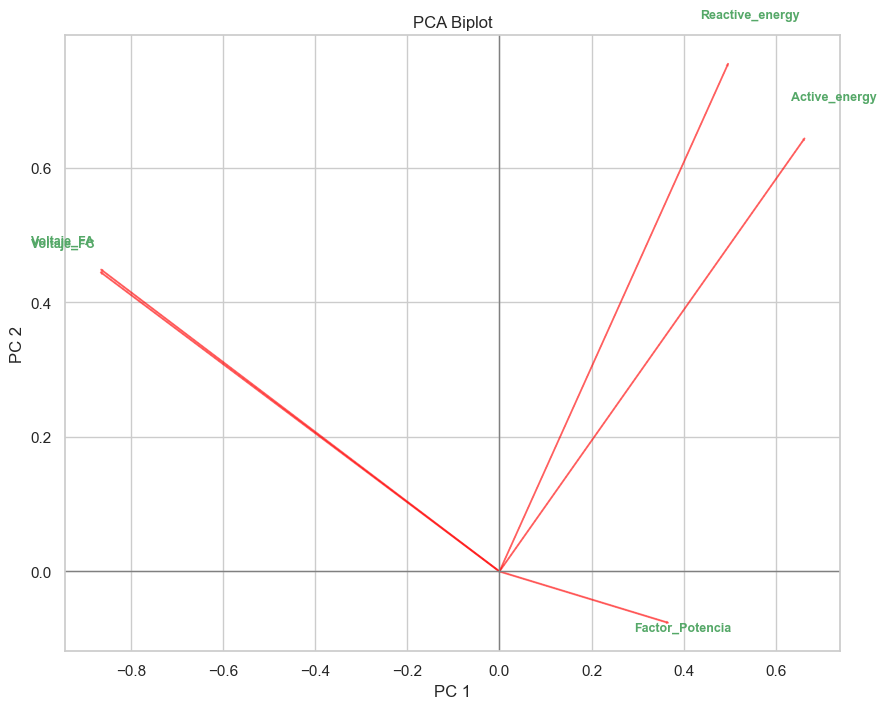

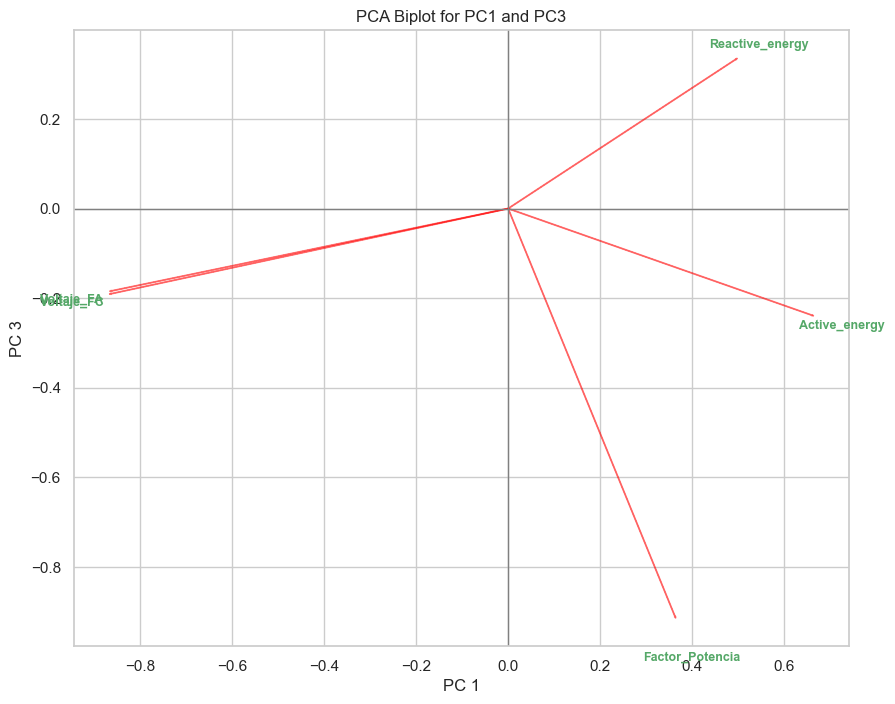

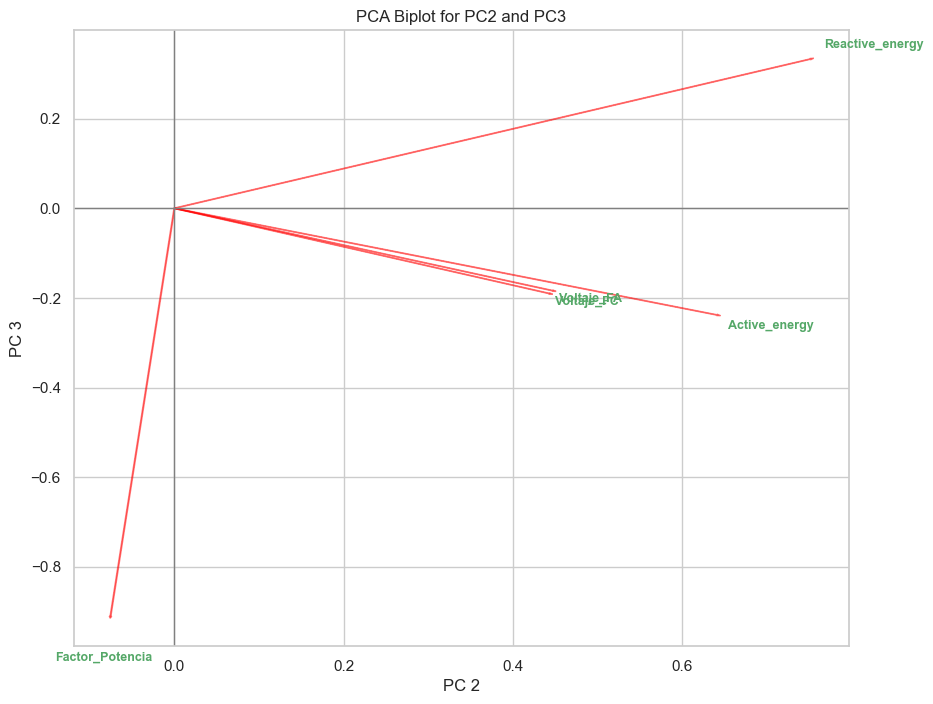

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import HTML

# Enhance plot aesthetics with Seaborn
sns.set(style="whitegrid")

# Load  data
combined_df = pd.read_csv('../data/output/consumo_datamart_silver.csv')

# Selecting numeric columns for PCA, replace these with your actual column names
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']
x = combined_df.loc[:, features].values

# Standardizing the features
x_standardized = StandardScaler().fit_transform(x)

# Apply PCA for 3 components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_standardized)

# Extract the loadings
loadings = pca.components_.T
# Create a DataFrame for loadings
# Convert loadings into a DataFrame
loadings_df = pd.DataFrame(data=loadings, columns=['PC1', 'PC2','PC3'], index=features)
print("Loadings directionality")
display(HTML(loadings_df.to_html()))
loadings_df

#contributioon
print("Loadings contribution")
loadings = pca.components_.T* np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings
# Convert loadings into a DataFrame
loadings_df = pd.DataFrame(data=loadings, columns=['PC1', 'PC2','PC3'], index=features)
display(HTML(loadings_df.to_html()))
loadings_df

# Creating the biplot
plt.figure(figsize=(10, 8))

# Plot the loadings (feature vectors)
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='red', alpha=0.5)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 1] * 1.1, feature, color='g', 
             ha='center', va='center',fontdict={'weight': 'bold', 'size': 9})

# Labels and title
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Biplot')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

# PC1 vs PC3 Biplot
plt.figure(figsize=(10, 8))
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 2], color='red', alpha=0.5)
    plt.text(loadings[i, 0] * 1.1, loadings[i, 2] * 1.1, feature, color='g', 
             ha='center', va='center', fontdict={'weight': 'bold', 'size': 9})
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('PCA Biplot for PC1 and PC3')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()

# PC2 vs PC3 Biplot
plt.figure(figsize=(10, 8))
for i, feature in enumerate(features):
    plt.arrow(0, 0, loadings[i, 1], loadings[i, 2], color='red', alpha=0.5)
    plt.text(loadings[i, 1] * 1.1, loadings[i, 2] * 1.1, feature, color='g', 
             ha='center', va='center', fontdict={'weight': 'bold', 'size': 9})
plt.xlabel('PC 2')
plt.ylabel('PC 3')
plt.title('PCA Biplot for PC2 and PC3')
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import HTML



# Load  data
combined_df =pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')
features = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']


# Standardizing the features
combined_df[features] = StandardScaler().fit_transform(combined_df[features])

# Apply PCA without specifying the number of components to retain all components
n_components = 3
pca = PCA(n_components=n_components)
pca.fit_transform(combined_df[features])


# Extract the loadings
loadings = pca.components_.T
# Create a DataFrame for loadings
# Convert loadings into a DataFrame
columns= []
loadings_df = pd.DataFrame(data=loadings, columns=['PC' + str(x+1) for x in range(n_components)], index=features)
print("Loadings directionality")
display(HTML(loadings_df.to_html()))


#contributioon
print("Loadings contribution")
loadings = pca.components_.T* np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings
# Convert loadings into a DataFrame
loadings_df = pd.DataFrame(data=loadings, columns=['PC' + str(x+1) for x in range(n_components)], index=features)
display(HTML(loadings_df.to_html()))




Loadings directionality


,PC1,PC2,PC3
Active_energy,0.435318,0.546258,-0.230506
Reactive_energy,0.326180,0.640285,0.322496
Voltaje_FA,-0.568508,0.380832,-0.178021
Voltaje_FC,-0.568963,0.377445,-0.184143
Factor_Potencia,0.239132,-0.064342,-0.881625


Loadings contribution


,PC1,PC2,PC3
Active_energy,0.660412,0.641094,-0.238033
Reactive_energy,0.494840,0.751445,0.333027
Voltaje_FA,-0.862470,0.446948,-0.183834
Voltaje_FC,-0.863162,0.442973,-0.190156
Factor_Potencia,0.362782,-0.075513,-0.910414


### 4.3 Interpretation of Biplots and Contribution of Loadings

PC1: Influenced by the voltage variables (Voltaje_FA and Voltaje_FC), and thus, this component represents a voltage dimension of the data.

PC2: Influenced by the energy variables (Active_energy and Reactive_energy), and thus, this component represents an energy consumption dimension.

PC3: Influenced by the power factor variable and by the residual of the variances.

In Spanish:


PC1: Influenciado por las vairables de voltaje (Voltaje_FA and Voltaje_FC), y de aqui, este componente representa una dimension de voltaje de l,os datos.

PC2: Influenciado por las variables de energia  (Active_energy and Reactive_energy), y de aqui, este componente representa un dimension  de consumo de energia

PC3: Influenciado por la variable de factor de potencia y por el residual de las varianzas.

### 4.4 Using the silver repository and performing reduction with consumption variables [Voltaje_FA, Voltaje_FC, Active_Energy, Reactive_Energy, and Power_Factor] and time components

['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia', 'Dia_Sin', 'Dia_Cos', 'Hora_Sin', 'Hora_Cos', 'Mes_Sin', 'Mes_Cos']


Text(0.5, 1.0, 'PCA Explained')

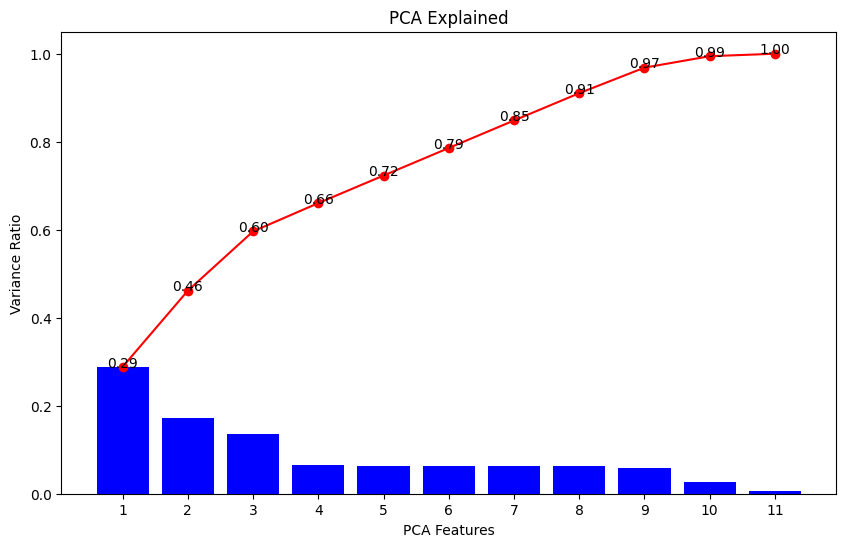

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


combined_df =pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')
columns_to_scale = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']


# Standardizing the features
combined_df[columns_to_scale] = StandardScaler().fit_transform(combined_df[columns_to_scale])

features = columns_to_scale + ["Dia_Sin","Dia_Cos","Hora_Sin","Hora_Cos","Mes_Sin","Mes_Cos"]
print(features)
pca = PCA()
pca.fit(combined_df[features])

# Calculate the variance ratios
variance_ratios = pca.explained_variance_ratio_

# Plot the explained variances for each component
features_range = range(1, pca.n_components_ + 1)
plt.figure(figsize=(10, 6))
plt.bar(features_range, variance_ratios, color='blue', label='Individual Explained Variance')

# Calculate and plot the cumulative explained variance
cumulative_variance_ratios = np.cumsum(variance_ratios)
plt.plot(features_range, cumulative_variance_ratios, c='red', marker='o', linestyle='-', label='Cumulative Explained Variance')

# Annotate the cumulative variance percentage on the plot
for i, cv in enumerate(cumulative_variance_ratios):
    plt.text(i + 1, cv, f"{cv:.2f}", ha='center')

# Adding labels and title
plt.xlabel('PCA Features')
plt.ylabel('Variance Ratio')
plt.xticks(features_range)
plt.title('PCA Explained')


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from IPython.display import HTML



# Load  data
combined_df =pd.read_csv('../data/output/consumo_datamart_silver_sectorecon_ohe.csv')
columns_to_scale = ['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'Voltaje_FC', 'Factor_Potencia']


# Standardizing the features
combined_df[columns_to_scale] = StandardScaler().fit_transform(combined_df[columns_to_scale])

features = columns_to_scale + ["Dia_Sin","Dia_Cos","Hora_Sin","Hora_Cos","Mes_Sin","Mes_Cos"]
n_components = 8
pca = PCA(n_components=n_components)
pca.fit_transform(combined_df[features])


# Extract the loadings
loadings = pca.components_.T
# Create a DataFrame for loadings
# Convert loadings into a DataFrame
columns= []
loadings_df = pd.DataFrame(data=loadings, columns=['PC' + str(x+1) for x in range(n_components)], index=features)
print("Loadings directionality")
display(HTML(loadings_df.to_html()))


#contributioon
print("Loadings contribution")
loadings = pca.components_.T* np.sqrt(pca.explained_variance_)
# Create a DataFrame for loadings
# Convert loadings into a DataFrame
loadings_df = pd.DataFrame(data=loadings, columns=['PC' + str(x+1) for x in range(n_components)], index=features)
display(HTML(loadings_df.to_html()))




Loadings directionality


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Active_energy,0.435268,0.545868,-0.219471,-0.082694,-0.002789,0.002297,0.006246,0.059195
Reactive_energy,0.325895,0.635838,0.324364,0.081511,0.007453,0.000640,-0.009073,0.008966
Voltaje_FA,-0.568034,0.380748,-0.174517,-0.020259,0.002169,0.002701,-0.001113,0.012502
Voltaje_FC,-0.568473,0.377417,-0.180818,-0.018060,0.001582,0.001881,-0.000431,0.011935
Factor_Potencia,0.239993,-0.058921,-0.874601,-0.082001,-0.000111,-0.003097,0.006702,0.043595
Dia_Sin,-0.001460,-0.003447,-0.004672,0.000593,0.687765,0.040952,-0.711808,0.096728
Dia_Cos,0.000304,-0.000348,0.003007,0.001837,0.703132,0.185374,0.685790,-0.030347
Hora_Sin,0.018201,0.033139,-0.023176,-0.145590,-0.077408,0.654671,-0.129045,-0.723350
Hora_Cos,-0.013469,-0.034647,0.019852,0.116622,-0.147225,0.731598,-0.018446,0.651675
Mes_Sin,0.019637,-0.054397,-0.054562,0.422104,0.064163,0.002178,-0.074425,-0.136361


Loadings contribution


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
Active_energy,0.660573,0.642081,-0.227754,-0.059274,-0.001974,0.001624,0.004415,0.041689
Reactive_energy,0.494585,0.747909,0.336607,0.058426,0.005274,0.000453,-0.006414,0.006315
Voltaje_FA,-0.862061,0.447858,-0.181104,-0.014521,0.001535,0.001910,-0.000787,0.008804
Voltaje_FC,-0.862728,0.443940,-0.187643,-0.012945,0.001119,0.001330,-0.000305,0.008405
Factor_Potencia,0.364218,-0.069307,-0.907612,-0.058777,-0.000078,-0.002190,0.004738,0.030703
Dia_Sin,-0.002215,-0.004055,-0.004848,0.000425,0.486651,0.028958,-0.503169,0.068122
Dia_Cos,0.000461,-0.000409,0.003121,0.001316,0.497524,0.131080,0.484777,-0.021372
Hora_Sin,0.027622,0.038980,-0.024051,-0.104356,-0.054773,0.462926,-0.091221,-0.509430
Hora_Cos,-0.020441,-0.040754,0.020601,0.083593,-0.104174,0.517321,-0.013039,0.458952
Mes_Sin,0.029802,-0.063985,-0.056621,0.302556,0.045401,0.001540,-0.052610,-0.096034


### 4.3 Interpretation of contribution of loadings with consumption variables and time variables

PC1: Influenced by the voltage variables (Voltaje_FA and Voltaje_FC), thus, this component represents a voltage dimension of the data.

PC2: Influenced by the energy variables (Active_energy and Reactive_energy), thus, this component represents an energy consumption dimension.

PC3: Influenced by the power factor variable.

PC4: Influenced by Month_Sin and Month_Cos, representing the month of the year and capturing a cyclic pattern.

PC5: Influenced by Day_Sin and Day_Cos, representing the day of the week and capturing a cyclic pattern.

PC6: Influenced by Hour_Sin and Hour_Cos, representing the hour of the day and capturing a cyclic pattern.

PC7 and PC8: Influenced by Day_Sin and Day_Cos, representing the day of the week and capturing a cyclic pattern.

In Spanish: 

PC1: Influenciado por las vairables de voltaje (Voltaje_FA and Voltaje_FC), y de aqui, este componente representa una dimension de voltaje de l,os datos.

PC2: Influenciado por las variables de energia  (Active_energy and Reactive_energy), y de aqui, este componente representa un dimension  de consumo de energia

PC3: Influenciado por la variable de factor de potencia 

PC4: influenciado por Mes_Sin  y Mes_Cos representando  mes del anio y capturando un patron ciclico.

PC5: influenciado por Dia_Sin  y Dia_Cos representando  dia de la semana y capturando un patron ciclico.

PC6: nfluenciado por Hora_Sin  y Hora_Cos representando  hora del dia y capturando un patron ciclico.

PC7 y PC8:  influenciado por Dia_Sin  y Dia_Cos representando  dia de la semana y capturando un patron ciclico.
